In [1]:
import scipy.sparse as spr
import scipy.sparse.linalg as spla
import sys
path2oti = '../../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

import pyoti.sparse as oti 
import pyoti.core   as coti
import pyoti.fem    as fem 
import pyoti.real   as r 

np = oti.np

import pyvista as pv
pv.set_plot_theme('Document')

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
#*****************************************************************************************************
def solve_2d_TransientHeat_NoTemps(Th, rho, Cp, dt, kk, hu, T0, Tw,Tinf, stats=True, solver = 'UMFPACK'):
    
    global times
    from timeit import default_timer as time
    
    # print("Setting up problem")
    
    start_time = time()
    
    alpha_t  = kk*dt/(rho*Cp)
    alpha2_t = hu*dt/(rho*Cp)
    
    ndim_analysis = 2
    
    els = Th.elements[2]
    
    # End elements to be sure memory is clean and free.
    fem.end_elements()
    
    nNodes = Th.nnodes
    nDOF = nNodes
    
    K = alg.lil_matrix((nDOF,nDOF))
    f = alg.zeros((nDOF,1))
    
    # print("\nStarting elemental computations.")
    
    #  INT 2D
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=4)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = True)
            
            Te = alg.zeros( ( elem.nbasis, 1 ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]

            el_i = 0

            for el in elems:
                Te[int(el_i),0] = T0[int(el),0]
                el_i += 1
            # end for 
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            NxNx = alg.dot( alg.transpose(elem.Nx), elem.Nx)
            NyNy = alg.dot( alg.transpose(elem.Ny), elem.Ny)
            NN   = alg.dot( alg.transpose(elem.N ), elem.N )
            
            Me = NN # (Mass matrix)
            Ke = alpha_t * (NxNx + NyNy) # (Stiffness matrix)
            Ae = alg.gauss_integrate( Me + Ke , elem.dV )

            fe = alg.gauss_integrate( alg.dot(Te,Me), elem.dV )            
          
            # assemble globals
            for k in range(elems.size):
        
                ii=int(elems[k])
            
                f[ii,0] = f[ii,0] + fe[k,0]
                
                for l in range(elems.size):

                    jj=int(elems[l])
            
                    K[ii,jj] = K[ii,jj] + Ae[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()   

    end_assmbly_time = time()
    # print("\nFinished assembly.\nSetting up boundary condition.")
    
    # applying convective + radiative boundary condiitions:
    bounds = ['bottom','top']
    for bd in bounds:
        
        els = Th.group_names[bd]['members'][0]
        for j in range(els['types'].size):

            elem = fem.element[ els['types'][j] ]

            if not elem.is_allocated():

                elem.end()
                elem.allocate(intorder=6)
                elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            # end if 

            elm_nodes = els['indices'][j]

            for i in range(elm_nodes.shape[0]):

                elems = elm_nodes[i,:]

                elem.set_coordinates(Th.x,Th.y,Th.z,elems)
                elem.compute_jacobian()
           
                NN = alg.dot(alg.transpose(elem.N),elem.N)

                Ae = alg.gauss_integrate( alpha2_t*NN, elem.dV)
                fe = alg.gauss_integrate( alpha2_t*Tinf*N, elem.dV)
                

                # assemble globals            
                for k in range(elems.size):

                    ii=int(elems[k])

                    f[ii,0] = f[ii,0] + fe[k,0]

                    for l in range(elems.size):

                        jj=int(elems[l])

                        K[ii,jj] = K[ii,jj] + Ae[k,l]

                    # end for 

                # end for 

            # end for

        # end for

        fem.end_elements()  
        
    # end for 
        
    #  Dirichlet
    TGV = 1e30
    
    EssentialNodes = Th.group_names['left']['nodes']
    
    for node in EssentialNodes:

        ii=int(node)

        f[ii,0] = f[ii,0] + Tw*TGV

        K[ii,ii] = K[ii,ii] + TGV

        # end for 
    # end for
    
    end_bc_time = time()
    
    #print("\nEnded boundary condition setup.\nStarting system solution.")
    
   
    K = K.tocsr()#(preserve_in=False)
    
    # print("\nConverted matrix to csr format. - Starting solution process.")
    
    u = alg.solve(K,f,solver=solver)
    
    # print("\nSolved problem.")
    
    end_solve_time = time()
    
    if stats:
        times['assembly'].append(  end_assmbly_time - start_time       )
        times['bc'].append( end_bc_time      - end_assmbly_time  )
        times['solve'].append(  end_solve_time   - end_bc_time      )
        times['total'].append( end_solve_time   - start_time        )
        
#         print("Assembly time:  {0:.6f} s ".format( end_assmbly_time - start_time       ) )
#         print("Boundary time:  {0:.6f} s ".format( end_bc_time      - end_assmbly_time ) )
#         print("Solution time:  {0:.6f} s ".format( end_solve_time   - end_bc_time      ) )
#         print("Total run time: {0:.6f} s ".format( end_solve_time   - start_time       ) )
#         print()
    # end if 

    return u,K,f

    #-----------------------------------------------------------------------------------------------------

In [3]:
#*****************************************************************************************************
def solve_2d_TransientHeat(Th, rho, Cp, dt, kk, hu, T0, Tw, Tinf, Uv, stats = True, solver = 'UMFPACK'):
    
    global times
    from timeit import default_timer as time
    
    # print("Setting up problem")
    
    start_time = time()
    
    alpha1_t = kk*dt/(rho*Cp)
    alpha2_t = hu*dt/(rho*Cp)
    alpha3_t = Uv*dt/(rho*Cp)
    
    ndim_analysis = 2
    
    els = Th.elements[2]
    
    # End elements to be sure memory is clean and free.
    fem.end_elements()
    
    nNodes = Th.nnodes
    nDOF = nNodes
    
    K = alg.lil_matrix((nDOF,nDOF))
    f = alg.zeros((nDOF,1))
    
    # print("\nStarting elemental computations.")
    
    #  INT 2D
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=4)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = True)

            fh = alg.zeros( ( elem.nbasis, 1 ) )
            r    = alg.zero(    nip = elem.nip   )
            rneg = alg.zero(    nip = elem.nip   )
            
            # Temps
            NT  = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            NxT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            NyT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            
    
            NN   = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NxNx = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NyNy = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )

            NN_tmp1 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp2 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp3 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp4 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            
            N_tmp1 = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            N_tmp2 = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            N_tmp3 = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            
            tmp_Ke = alg.zeros( ( elem.nbasis, elem.nbasis ) )
            tmp_fe = alg.zeros( ( elem.nbasis,       1     ) )
            tmp_To = alg.zeros( ( elem.nbasis,       1     ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]

            el_i = 0

            for el in elems:
                tmp_To[int(el_i),0] = T0[int(el),0]
                el_i += 1
            # end for 
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            Nx = elem.Nx
            Ny = elem.Ny
            N  = elem.N # (1x3)
            
            
            alg.transpose(Nx, out = NxT)
            alg.transpose(Ny, out = NyT)
            alg.transpose( N, out = NT )
            
            alg.dot( NxT, Nx, out = NxNx )
            alg.dot( NyT, Ny, out = NyNy )
            alg.dot( NT ,  N, out = NN   )
            
            # problem heat(Theta,w)=
            #    -int2d(Th)(   dx(Theta) * dx(w) ) // -- Goes in K
            #    -int2d(Th)(   dy(Theta) * dy(w) ) // -- Goes in K
            #    +int2d(Th)(   Q * w             ) // -- RHS only
            #
            #    -int1d(Th,4)( w * Bi1 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)( w * Bi2 * Theta   ) // -- Goes in K
            #    -int1d(Th,2)( w * Bi2           );// -- RHS only
                      
            alg.sum( NxNx, NyNy, out = NN_tmp1 )
            alg.mul(alpha1_t, NN_tmp1, out = NN_tmp2)
            alg.mul(1+alpha3_t, NN, out = NN_tmp3)
            alg.sum( NN_tmp3, NN_tmp2, out = NN_tmp1 )
            alg.gauss_integrate( NN_tmp1, elem.dV, out = tmp_Ke )
            

#             To = alg.dot_product(N,tmp_To)
            
            # print(To)
            
            alg.dot( NN, tmp_To, out = N_tmp1 )
            alg.mul( NT, alpha3_t * Tinf, out = N_tmp2 )
            alg.sum( N_tmp1, N_tmp2, out = N_tmp3 )
            alg.gauss_integrate( N_tmp3, elem.dV, out = tmp_fe )
            
          
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])
            
                f[ii,0] = f[ii,0] + tmp_fe[k,0]
                
                for l in range(elems.size):

                    jj=int(elems[l])
            
                    K[ii,jj] = K[ii,jj] + tmp_Ke[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()   

    end_assmbly_time = time()
    # print("\nFinished assembly.\nSetting up boundary condition.")
    
    # applying convective + radiative boundary condiitions:
    bounds = ['bottom','top']
    for bd in bounds:
        
        els = Th.group_names[bd]['members'][0]
        for j in range(els['types'].size):

            elem = fem.element[ els['types'][j] ]

            if not elem.is_allocated():

                elem.end()
                elem.allocate(intorder=6)
                elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            # end if 

            elm_nodes = els['indices'][j]

            for i in range(elm_nodes.shape[0]):

                elems = elm_nodes[i,:]

                elem.set_coordinates(Th.x,Th.y,Th.z,elems)
                elem.compute_jacobian()

                N  = alg.transpose(elem.N)            
                NN = alg.dot(N,elem.N)

                #    -int1d(Th,4)(  w * Bi1 * Theta   ) // -- Goes in K
                #    -int1d(Th,2)(  w * Bi2 * Theta   ) // -- Goes in K
                #    -int1d(Th,2)(  w * Bi2           );// -- RHS only

                tmp_Ke = alg.gauss_integrate( alpha2_t*NN, elem.dV)
                tmp_fe = alg.gauss_integrate( alpha2_t*Tinf*N, elem.dV)

                # assemble globals            
                for k in range(elems.size):

                    ii=int(elems[k])

                    f[ii,0] = f[ii,0] + tmp_fe[k,0]

                    for l in range(elems.size):

                        jj=int(elems[l])

                        K[ii,jj] = K[ii,jj] + tmp_Ke[k,l]

                    # end for 

                # end for 

            # end for

        # end for

        fem.end_elements()  
        
    # end for 
        
    #  Dirichlet
    TGV = 1e30
    
    EssentialNodes = Th.group_names['left']['nodes']
    
    for node in EssentialNodes:

        ii=int(node)

        f[ii,0] = f[ii,0] + Tw*TGV

        K[ii,ii] = K[ii,ii] + TGV

        # end for 
    # end for
    
    end_bc_time = time()
    
    #print("\nEnded boundary condition setup.\nStarting system solution.")
    
   
    K = K.tocsr()#(preserve_in=False)
    
    # print("\nConverted matrix to csr format. - Starting solution process.")
#     print("This is K:")
#     print(K)
    
#     print("This is f:")
#     print(f)
    u = alg.solve(K,f,solver=solver)
    
    # print("\nSolved problem.")
    
    end_solve_time = time()
    
    if stats:
        times['assembly'].append(  end_assmbly_time - start_time       )
        times['bc'].append( end_bc_time      - end_assmbly_time  )
        times['solve'].append(  end_solve_time   - end_bc_time      )
        times['total'].append( end_solve_time   - start_time        )
        
#         print("Assembly time:  {0:.6f} s ".format( end_assmbly_time - start_time       ) )
#         print("Boundary time:  {0:.6f} s ".format( end_bc_time      - end_assmbly_time ) )
#         print("Solution time:  {0:.6f} s ".format( end_solve_time   - end_bc_time      ) )
#         print("Total run time: {0:.6f} s ".format( end_solve_time   - start_time       ) )
#         print()
    # end if 

    return u,K,f

    #-----------------------------------------------------------------------------------------------------

# Problem parameters:

In [99]:
# Set algebra to OTI
fem.set_global_algebra(r)
alg = fem.get_global_algebra()

order = 2

b = 51/1000
δ = 4.75/1000

rho  = 4430.0# + alg.e(7,order=order)
Cp   = 580.0 # + alg.e(4,order=order)
dt   = 1.0   # + alg.e(5,order=order)
k    = 7.1   # + alg.e(2,order=order)
hu   = 114.0 # + alg.e(6,order=order)
Tinf = 283.0 # + alg.e(1,order=order)
T0   = 283.0 # + alg.e(3,order=order)
Tw   = 389.0 # + alg.e(8,order=order)
Uv   = 735.0 # + alg.e(9,order=order)


In [100]:
Th = fem.square(b.real,δ.real,ndivs=[1000,10],element_order=1,quads=True,save=False, structured=True)

Th

< mesh (pyoti.real) object with 11011 nodes, 12024 elements of types ( point1 (4), line2 (2020), quad4 (10000) ) >

In [6]:
# Perturb in the x direction:
P = (Th.x+b/2)/b # P function.
Th.x = Th.x + P*alg.e(10,order=order) 

In [ ]:
p = pv.Plotter(window_size=[800,300])


grid = Th.to_pv()
p.add_mesh(grid, show_edges=True, line_width=1,reset_camera=True,cmap='jet')#,clim=[Tinf,Tw])
p.show_axes()

p.camera_position = 'xy'
p.camera.Zoom(2.5)

# Closes and finalizes movie
p.show(jupyter_backend='pythreejs')

In [101]:
times = {}
times['assembly'] = []
times['bc'] = []
times['solve'] = []
times['total'] = []

solver = 'SuperLU'
# solver = 'umfpack'
# solver = 'cholesky'
tmax = 350

Told = alg.zeros((Th.nnodes,1))
Told[:,:]=T0 # It does not take the perturbation from Tinf ...


# print(Told)
neval = int(tmax/dt.real)
# Teval = np.zeros(neval,dtype=object)

from timeit import default_timer as time
start_time = time()

for i in range(neval):
    T,K,f = solve_2d_TransientHeat(
        Th, 
        rho, 
        Cp, 
        dt, 
        k, 
        hu, 
        Told, 
        Tw,
        Tinf,
        Uv,
        stats=True, 
        solver=solver
    )
    
#     Teval[i] = T
    Told = T
#     ass_time = np.average(times['assembly'] ) + np.average(times['bc'])       
#     sol_time = np.average(times['solve'] ) 
#     print("-Simulation time {0:3.0f}s, [Assm: {1:6.4f}s, Sol: {2:6.4f}s].".format((i+1)*dt.real,ass_time,sol_time), end = "\r")
    print("-Simulation time {0:3.0f}s. Total solution time {1:6.4f}s".format((i+1)*dt.real,times['total'][-1]), end = "\r")
# end for 

end_time = time()

print("Total run time for {0}: {1:.6f} s ".format(type(T),end_time-start_time ) )

# # Convert 
# θeval = np.zeros(neval,dtype=object)
# for i in range(neval):
#     θeval[i] = (Teval[i]-Tinf)/(Tw-Tinf)
# # end for

Total run time for <class 'pyoti.real.dmat'>: 118.304295 s 


In [8]:
# alg.zeros((5,1),order=2)
Teval1 = Teval
θeval1 = θeval

In [9]:
p = pv.Plotter(window_size=[600,400])


grid = Th.to_pv(pd = [θeval[-1].real],pd_names=['T'])
p.add_mesh(grid, show_edges=False, line_width=1,reset_camera=True,cmap='jet')#,clim=[Tinf,Tw])
p.show_axes()

p.camera_position = 'xy'
p.camera.Zoom(1.5)

# Closes and finalizes movie
p.show(jupyter_backend='pythreejs')

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='#fefefe', intensity=0.25, posi…

In [ ]:
dir_helper = coti.get_dHelp()
help(dir_helper.get_ndir_total)
dir_helper.get_ndir_total(10,2)

In [11]:
# 1000x10 grid CPU times. 350s simulation, dt = 1s.
(  114.60 / 365.785,  # Intrinsic real
  365.785 / 365.785,  # OTI-real like
  940.739 / 365.785,  # OTI + First order for 10 vars.
 2072.619 / 365.785)  # OTI + second order for 10 vars.

(0.31329879574066727, 1.0, 2.571835914539962, 5.666221960988012)

In [ ]:
# 100x4 grid CPU times. 350s simulation, dt = 1s.
(5.26376 / 15.2189,  # Intrinsic real
 15.2189 / 15.2189,  # OTI-real like
 38.3943 / 15.2189,  # OTI + First order for 10 vars.
 83.6002 / 15.2189)  # OTI + second order for 10 vars.

In [13]:
Teval[-1][100,0]

355.3549 + 0.3173 * e([1]) + 1.9961 * e([2]) + 0.0001 * e([3]) - 0.0000 * e([4]) + 0.0102 * e([5]) - 0.1224 * e([6]) - 0.0000 * e([7]) + 0.6826 * e([8]) - 0.0003 * e([9]) - 526.9477 * e([10]) - 0.0188 * e([1,2]) - 0.1833 * e([[2,2]]) - 0.0000 * e([2,3]) - 0.0000 * e([1,4]) + 0.0000 * e([2,4]) + 0.0000 * e([3,4]) - 0.0000 * e([[4,2]]) + 0.0007 * e([1,5]) - 0.0000 * e([2,5]) - 0.0008 * e([3,5]) + 0.0001 * e([4,5]) - 0.0377 * e([[5,2]]) + 0.0012 * e([1,6]) + 0.0052 * e([2,6]) - 0.0000 * e([3,6]) + 0.0000 * e([4,6]) - 0.0006 * e([5,6]) + 0.0004 * e([[6,2]]) - 0.0000 * e([1,7]) + 0.0000 * e([2,7]) + 0.0000 * e([3,7]) - 0.0000 * e([4,7]) + 0.0000 * e([5,7]) + 0.0000 * e([6,7]) - 0.0000 * e([[7,2]]) + 0.0188 * e([2,8]) - 0.0000 * e([4,8]) + 0.0001 * e([5,8]) - 0.0012 * e([6,8]) - 0.0000 * e([7,8]) + 0.0000 * e([1,9]) + 0.0000 * e([2,9]) - 0.0000 * e([3,9]) + 0.0000 * e([4,9]) - 0.0000 * e([5,9]) + 0.0000 * e([6,9]) + 0.0000 * e([7,9]) - 0.0000 * e([8,9]) + 0.0000 * e([[9,2]]) + 4.9674 * e([1,

In [ ]:
plt.figure()

grid = Th.to_pv(pd = [Teval[0].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

grid = Th.to_pv(pd = [Teval1[0].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

# grid = Th.to_pv(pd = [Teval[-1].real],pd_names=['T'])
grid = Th.to_pv(pd = [Teval[-1].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

grid = Th.to_pv(pd = [Teval1[-1].rom_eval([1],[10.0]).real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

ax = plt.gca()
lines = ax.get_lines()
lines[0].set_label("t={0}s (Tinf)".format(dt))
lines[1].set_label("t={0}s (Tinf+1)".format(dt))

lines[2].set_label("t={0}s (Tinf)".format(tmax))
lines[3].set_label("t={0}s (Tinf+1)".format(tmax))

plt.legend()
plt.show()

In [ ]:
Teval[0]

In [ ]:
plt.figure()

grid = Th.to_pv(pd = [Teval[0].get_deriv([[5,1]])],pd_names=[r'$\partial T/\partial T_{\infty}$'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

grid = Th.to_pv(pd = [Teval[-1].get_deriv([[5,1]])],pd_names=[r'$\partial T/\partial T_{\infty}$'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

ax = plt.gca()
lines = ax.get_lines()

lines[0].set_label("t={0}s".format(dt))
lines[1].set_label("t={0}s".format(tmax))

plt.legend()
plt.show()

In [ ]:
plt.figure()

grid = Th.to_pv(pd = [θeval[0].real],pd_names=[r'$\theta$'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

grid = Th.to_pv(pd = [θeval[-1].real],pd_names=[r'$\theta$'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

plt.show()

<IPython.core.display.Javascript object>


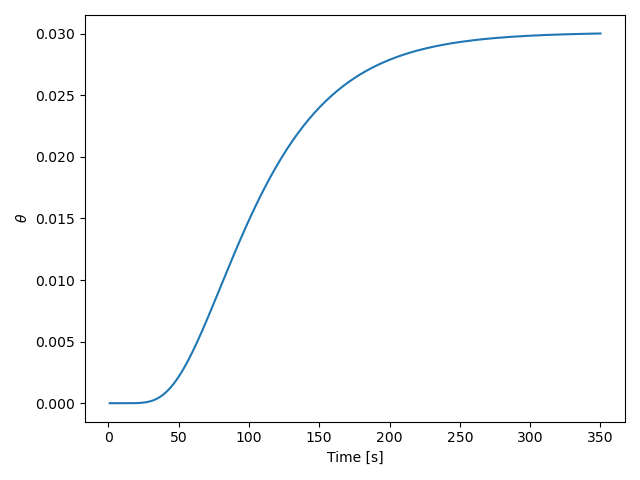

In [87]:


nnodes = Th.group_names['right']['nodes'].size-2
imid = nnodes//2 # Extract the middle node.
id_node = int(Th.group_names['right']['nodes'][imid])

# plt.plot([t[0],t[-1]],[θss,θss])
tplot = np.arange(dt.real,dt.real+tmax,dt.real)
incsplot = np.arange(1,neval+1)
Tplot = np.zeros(tplot.size)
θplot = np.zeros(tplot.size)
Sθ_Tinf = np.zeros(tplot.size)
S2θ_Tinf = np.zeros(tplot.size)
dθ_dt = np.zeros(tplot.size)
Sθ_k = np.zeros(tplot.size)
Sθ_Cp = np.zeros(tplot.size)
Sθ_T0 = np.zeros(tplot.size)

for i in range(neval):
    Tplot[i] = Teval[i][id_node,0].real
    θplot[i] = θeval[i][id_node,0].real
    Sθ_Tinf[i] = θeval[i][id_node,0].get_deriv(1)*(Tw-Tinf).real
    Sθ_k[i] = θeval[i][id_node,0].get_deriv(2)*(k.real).real
    Sθ_T0[i] = θeval[i][id_node,0].get_deriv(3)*(Tw-Tinf).real
    Sθ_Cp[i] = θeval[i][id_node,0].get_deriv(4)*(Cp.real).real
    dθ_dt[i] = θeval[i][id_node,0].get_deriv(5)*(tmax).real
    
    S2θ_Tinf[i] = θeval[i][id_node,0].get_deriv([[1,2]])*(Tw-Tinf).real**2



dθ_dt=dθ_dt*tmax/(tplot*incsplot)


<IPython.core.display.Javascript object>


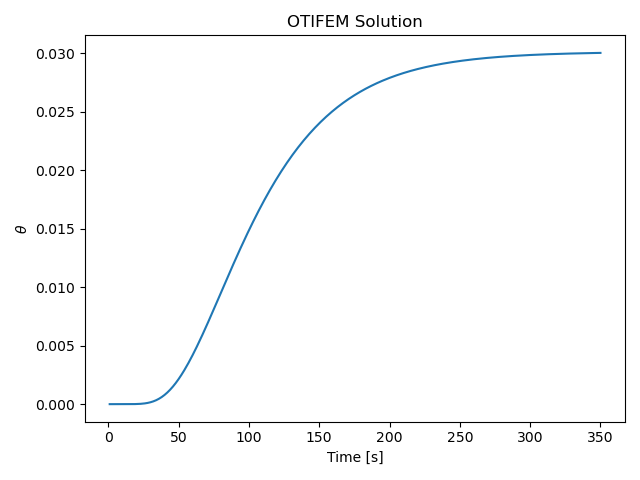

In [144]:
plt.figure()

plt.plot(tplot,θplot)


plt.title("OTIFEM Solution")
plt.xlabel("Time [s]")
# plt.xlabel("x [m]")
plt.ylabel(r"$\theta$")
plt.tight_layout()
plt.show()
plt.savefig("theta.pdf",dpi=300)

In [70]:
tplot.size

350

<IPython.core.display.Javascript object>


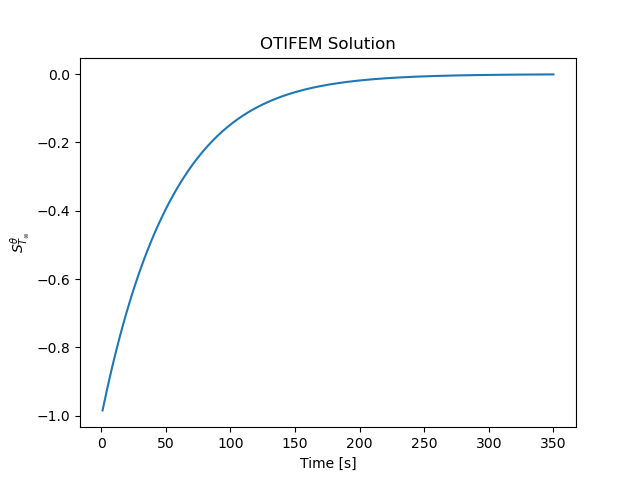

In [143]:
plt.figure()
plt.plot(tplot,Sθ_Tinf)

plt.title("OTIFEM Solution")
plt.ylabel(r"$S^\theta_{T_\infty}$")
# plt.xlabel("x [m]")
plt.xlabel("Time [s]")

plt.show()
plt.savefig("S_theta_wrt_Tinf.pdf",dpi=300)

<IPython.core.display.Javascript object>


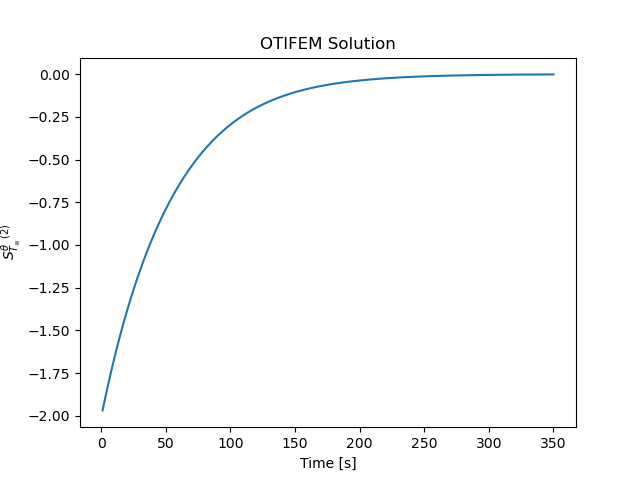

In [142]:
plt.figure()
plt.plot(tplot,S2θ_Tinf)

plt.title("OTIFEM Solution")
plt.ylabel(r"${S^\theta_{T_\infty}}^{(2)}$")
# plt.xlabel("x [m]")
plt.xlabel("Time [s]")

plt.show()
plt.savefig("S2_theta_wrt_Tinf.pdf",dpi=300)

<IPython.core.display.Javascript object>


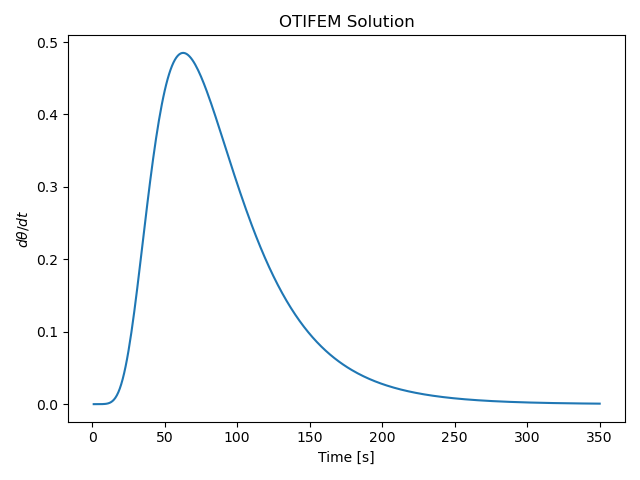

In [141]:
plt.figure()
plt.plot(tplot,dθ_dt)

plt.title("OTIFEM Solution")
plt.ylabel(r"$d\theta/dt$")
# plt.xlabel("x [m]")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

plt.savefig("dtheta_dt.pdf",dpi=300)

<IPython.core.display.Javascript object>


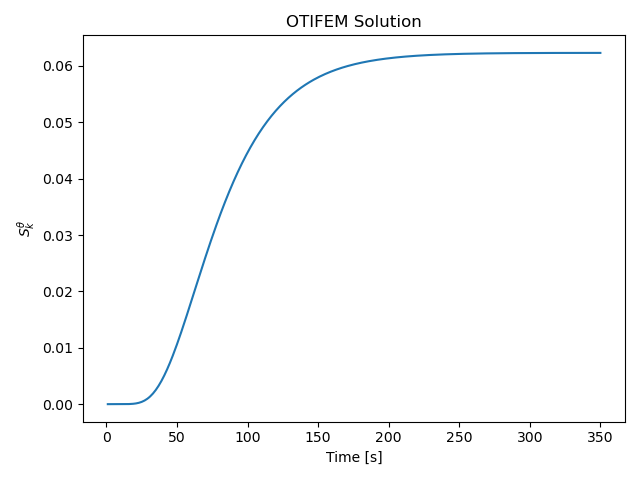

In [140]:
plt.figure()
plt.plot(tplot,Sθ_k)

plt.title("OTIFEM Solution")
plt.ylabel(r"$S^\theta_{ k}$")
# plt.xlabel("x [m]")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()
plt.savefig("S_theta_wrt_k.pdf",dpi=300)

<IPython.core.display.Javascript object>


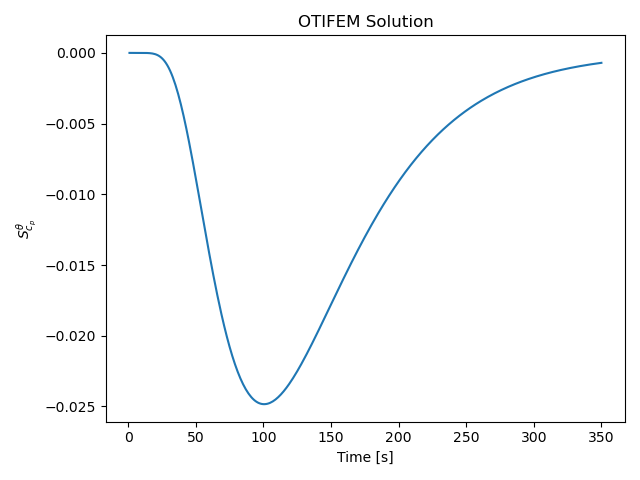

In [139]:
plt.figure()
plt.plot(tplot,Sθ_Cp)

plt.title("OTIFEM Solution")
plt.ylabel(r"$S^\theta_{ c_p}$")
# plt.xlabel("x [m]")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()
plt.savefig("S_theta_wrt_cp.pdf",dpi=300)

<IPython.core.display.Javascript object>


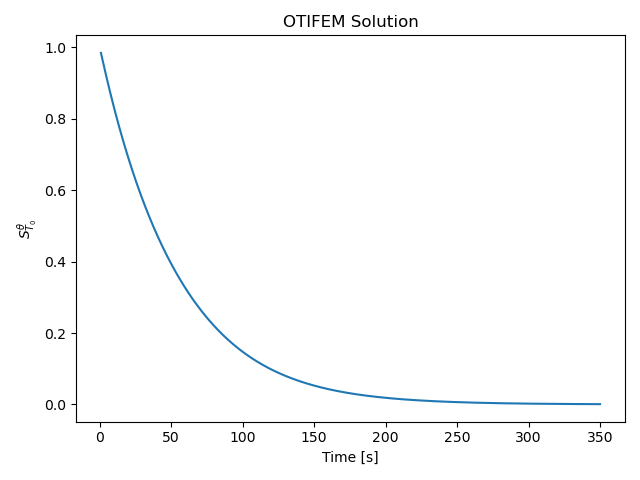

In [138]:
plt.figure()
plt.plot(tplot,Sθ_T0)

plt.title("OTIFEM Solution")
plt.ylabel(r"$S^\theta_{ T_0}$")
# plt.xlabel("x [m]")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()
plt.savefig("S_theta_wrt_T0.pdf",dpi=300)

In [32]:
Teval.size

350

In [36]:
for i in range(Teval.size):
    TTT = Teval[i]
    oti.save(TTT,"res/T_inc_{0:03d}_n{1:d}.matso".format(i+1,order))

In [35]:
"{:03d}".format(1)

'001'

In [104]:
# oti_n2_times = times
real_times = times

In [126]:
# def moving_average(a, n=3) :
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n

<IPython.core.display.Javascript object>


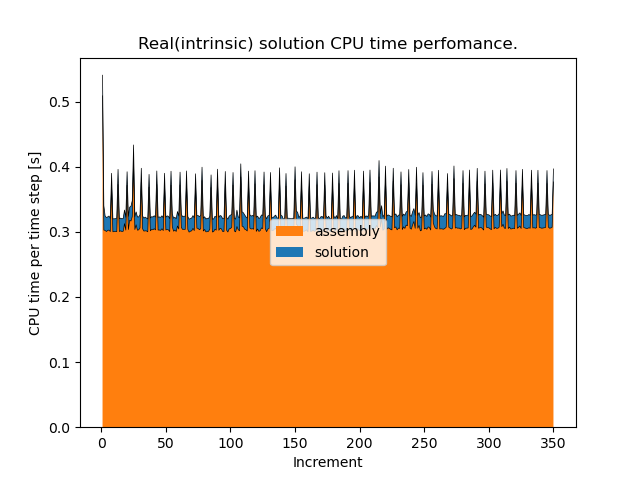

In [145]:
plt.figure()
# real_time = real_times['total']
assm_time = (np.array(real_times['assembly']))#/real_time
bc_time =   (np.array(real_times['bc']))      #/real_time
solve_time= (np.array(real_times['solve']))   #/real_time

l1 = assm_time
l2 = assm_time+bc_time
l3 = assm_time+bc_time+solve_time

# plt.plot(incsplot,real_time,'C4',linewidth=1.0,label='Real time')
plt.plot(incsplot,l2,'k',linewidth=0.5)
plt.plot(incsplot,l3,'k',linewidth=0.5)
plt.fill_between(incsplot,0,l2,facecolor='C1',label='assembly')
# plt.fill_between(incsplot,l1,l2,label='bc')
plt.fill_between(incsplot,l2,l3,facecolor='C0',label='solution')

plt.axis([ None, None, 0, None])
plt.ylabel(r"CPU time per time step [s]")
plt.title("Real(intrinsic) solution CPU time perfomance.")
plt.xlabel("Increment")
plt.legend(loc='center')
plt.show()
plt.savefig("real_cpu_time.pdf",dpi=300)

<IPython.core.display.Javascript object>


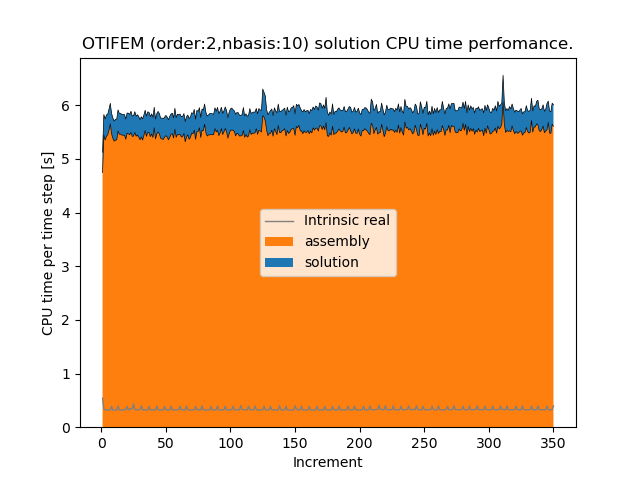

In [148]:
plt.figure()
real_time = real_times['total']
assm_time = np.array(oti_n2_times['assembly'])#/real_time
bc_time = np.array(oti_n2_times['bc'])        #/real_time
solve_time=np.array(oti_n2_times['solve'])    #/real_time

l1 = assm_time
l2 = assm_time+bc_time
l3 = assm_time+bc_time+solve_time

plt.plot(incsplot,real_time,'gray',linewidth=1.0,label='Intrinsic real')
plt.plot(incsplot,l2,'k',linewidth=0.5)
plt.plot(incsplot,l3,'k',linewidth=0.5)
plt.fill_between(incsplot,0,l2,facecolor='C1',label='assembly')
# plt.fill_between(incsplot,l1,l2,label='bc')
plt.fill_between(incsplot,l2,l3,facecolor='C0',label='solution')

plt.axis([ None, None, 0, None])
plt.ylabel(r"CPU time per time step [s]")
plt.title("OTIFEM (order:{0},nbasis:{1}) solution CPU time perfomance.".format(2,10))
plt.xlabel("Increment")
plt.legend(loc='center')
plt.show()
plt.savefig("oti_cpu_time_n2.pdf",dpi=300)

In [ ]:
# p = pv.Plotter(window_size=[600,400])
pv.set_plot_theme('Document')
p = pv.Plotter(window_size=[800,400],notebook=False, off_screen=True)

# p.open_gif("export.gif")
p.open_movie("export.mp4")


grid = Th.to_pv(pd = [Teval[0].real],pd_names=['T'])
p.add_mesh(grid, show_edges=False, line_width=1,reset_camera=True)#,clim=[Tinf,Tw])
p.show_axes()
p.camera_position = 'xy'
t=0
for Tplot in Teval:
    # Tplot = Teval[-1]
    
#     p.update_scalars(Tplot.real[:,0], render=False)
    grid['T']=Tplot.real[:,0]
    
#     p.show(jupyter_backend='pythreejs')
    p.add_text(f"Iteration: {t} s", name='time-label')
    p.render()
    p.write_frame()
    t+=dt

# Closes and finalizes movie
p.close()

In [ ]:
# grid['T']=Tplot.real[:,0]Mauricio Aristizabal

In [ ]:
i = -1
np.max(Teval[i].real),np.min(Teval[i].real)

# Analytic solution

In [ ]:
def analytic_solution(x, t, b, δ, ρ, Cp, dt, k, hu, T0, Tw, Tinf,base = np,nterms = 100 ):
    
    # Adimensionalization of input parameters
    θ0 = (T0 - Tinf)/(Tw - Tinf)
    X = x/b
    NN = (2*hu*b**2)/(k*δ)
    N = base.sqrt(NN)
    τ = t*k/(b**2*ρ*Cp)
    θτ  = 0
    
    θss = base.cosh(N*X)/base.cosh(N)
    
    for n in range(1,nterms+1):
        
        λn = ( ( 2 * n - 1) / 2 ) * np.pi
        sign = ( -1 )**( n + 1 )
        
        t1 = θ0 / λn - ( λn**2 ) / ( NN + λn**2 )
        t2 = base.cos( λn * X )
        t3 = base.exp( -( NN + λn**2 ) * τ )
        
        θτ += sign * t1 * t2 * t3
        
    θτ *= 2
    
    θ = θss+θτ
    T = θ*(Tw-Tinf)+Tinf
    
    return T,θ,θτ,θss

In [ ]:
T0 = Tinf

t = np.arange(dt,(neval+1)*dt,dt)

x = np.linspace( 0, b, 100 )

Tanaly = np.zeros((t.size,x.size))
θanaly = np.zeros((t.size,x.size))

i=0

for ti in t:
    
    Ti,θi,θτi,θssi = analytic_solution(x, ti, 
                                   b.real, 
                                   δ.real, 
                                   rho.real, 
                                   Cp.real, 
                                   dt.real, 
                                   k.real, 
                                   hu.real, 
                                   T0.real, 
                                   Tw.real, 
                                   Tinf.real,
                                   base = np,
                                   nterms = 1000 )
    Tanaly[i,:] = Ti
    θanaly[i,:] = θi
    i+=1
    
    
print(i)

In [ ]:
θeval[0].size

<IPython.core.display.Javascript object>


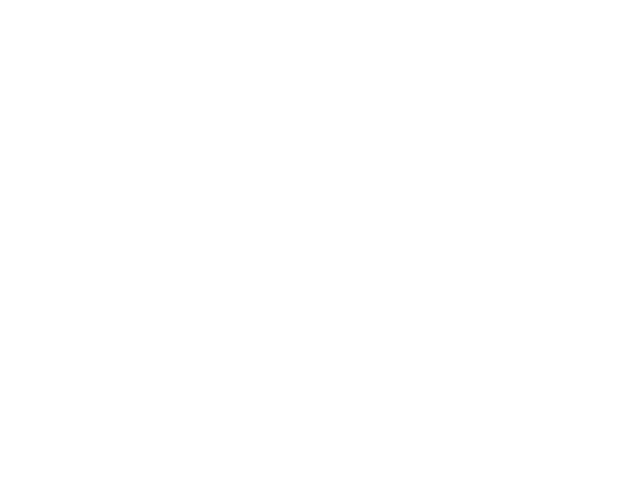

NameError: name 'x' is not defined

In [149]:
plt.figure()

# plt.plot([t[0],t[-1]],[θss,θss])
xi =  0
i  = -1

plt.plot(b-x,θanaly[i,:],'x-',label='Analytic')
# plt.plot(x,θanaly[i,:])
# plt.plot(x,Tvec[:,xi])
# plt.plot(t,θτ)
# plt.plot(t,θ)
grid = Th.to_pv(pd = [θeval[i].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

ax = plt.gca()
line_from_plotoverline = ax.get_lines()[-1]
line_from_plotoverline.set_label("OTIFEM")
# line_from_pltoverline.set_marker("")

plt.title("Time {0}[s]".format(t[i]))
plt.xlabel("x [m]")
plt.ylabel(r"$\theta$")
plt.legend()
plt.show()


In [ ]:
plt.figure()


xi = -1

plt.plot(t,θanaly[:,0],'-',label='Analytic')
plt.plot(tplot,θplot,label='OTIFEM')
# plt.plot(x,θanaly[i,:])
# plt.plot(x,Tvec[:,xi])
# plt.plot(t,θτ)
# plt.plot(t,θ)


plt.title("x = b [m]")
plt.xlabel("Time [s]")
plt.ylabel(r"$\theta$")
plt.legend()
plt.show()

In [151]:
θplot

array([-4.77270215e-14,  9.25046203e-13,  9.32124818e-12,  5.51579579e-11,
        2.47096197e-10,  9.09758005e-10,  2.87660036e-09,  8.03923978e-09,
        2.02713134e-08,  4.68427052e-08,  1.00411779e-07,  2.01629837e-07,
        3.82319782e-07,  6.89111892e-07,  1.18734664e-06,  1.96500036e-06,
        3.13636137e-06,  4.84518628e-06,  7.26709545e-06,  1.06110184e-05,
        1.51195664e-05,  2.10682799e-05,  2.87637717e-05,  3.85408437e-05,
        5.07587104e-05,  6.57964938e-05,  8.40481756e-05,  1.05917203e-04,
        1.31810936e-04,  1.62135111e-04,  1.97288478e-04,  2.37657747e-04,
        2.83612934e-04,  3.35503204e-04,  3.93653250e-04,  4.58360248e-04,
        5.29891383e-04,  6.08481962e-04,  6.94334069e-04,  7.87615744e-04,
        8.88460645e-04,  9.96968142e-04,  1.11320380e-03,  1.23720021e-03,
        1.36895807e-03,  1.50844757e-03,  1.65560990e-03,  1.81035899e-03,
        1.97258326e-03,  2.14214759e-03,  2.31889516e-03,  2.50264950e-03,
        2.69321638e-03,  

In [ ]:
Tvec[0,:]

In [ ]:
fig = plt.figure()

# plt.plot([t[0],t[-1]],[θss,θss])
xi = 0
i=499
plt.plot(b-x,Tvec[0,:],label='t0')
plt.plot(b-x,Tvec[-1,:],label='tend')
# plt.plot(x,Tvec[:,xi])
# plt.plot(t,θτ)
# plt.plot(t,θ)

# plt.xlabel("Time [s]")



ln, = plt.plot(b-x,Tvec[0,:],'x')

def init():
    plt.xlabel("x [m]")
    plt.ylabel("Temperatura [K]")
    plt.axis([None,None,Tinf-10,Tw+10])
    return ln,

def update(frame):
    plt.title("Simulation time: {0}s".format(frame*dt))
#     ln.set_data(b-x, Tvec[frame,:])
    return ln,

ani = FuncAnimation(fig, update, frames=Tvec.shape[0]-1,
                    init_func=init, blit=True)
plt.show()

In [ ]:
fig = plt.figure()
i=0

grid = Th.to_pv(pd = [Teval[0].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

# grid = Th.to_pv(pd = [Teval[i].real],pd_names=['T'])
# grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)
# ln, = plt.plot([],[])# Dummy
ln, = plt.plot(b-x, Tvec[0,:],'xk',label='Analytic')
grid = Th.to_pv(pd = [Teval[-1].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)



grid = Th.to_pv(pd = [Teval[i].real],pd_names=['T'])
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

ax = plt.gca()
# ax.set_xlabel("x [m]")
# ax.set_ylabel("Temperatura [K]")
# ax.get_lines()[2].remove()

# From analytic solution
# ln, = plt.plot(b-x,Tvec[i,:],'xr')

plt.legend()
def init():
    
    ax.set_xlabel("x [m]")
    ax.set_ylabel("Temperatura [K]")
    plt.axis([None,None,Tinf-10,Tw+10])
    return ln,

def update(frame):
    
    lnes = ax.get_lines()
    lnes[-1].remove()
    grid = Th.to_pv(pd = [Teval[frame].real],pd_names=['T'])
    grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)
    
    ax.get_lines()[-1].set_color('C3')
    ax.set_title("Simulation time: {0}s".format((frame+1)*dt))
    ax.set_xlabel("x [m]")
    ax.set_ylabel("Temperatura [K]")
    ln.set_data(b-x, Tvec[frame,:])
    return ln,

ani = FuncAnimation(fig, update, frames=499,
                    init_func=init, blit=True)

plt.show()

In [ ]:
len(Teval)

In [ ]:
grid.plot_over_line([-b/2,0,0],[b/2,0,0],figure=False,show=False)

In [ ]:
lne = ax.get_lines()[1]

In [ ]:
lne.set_color('r')

In [ ]:
p = pv.Plotter(window_size=[600,400])


grid = Th.to_pv()
p.add_mesh(grid, show_edges=True, line_width=1,reset_camera=True,cmap='jet')#,clim=[Tinf,Tw])
p.show_axes()

p.camera_position = 'xy'
p.camera.Zoom(1.5)

# Closes and finalizes movie
p.show(jupyter_backend='pythreejs')